# NumTopics: all datasets

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import itertools
import os
import time
import sys

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
sys.path.insert(0, '../..')  # develop topicnet
sys.path.insert(0, '..')     # topnum

In [5]:
from topicnet.cooking_machine.models import TopicModel
from topicnet.cooking_machine.dataset import Dataset

from topnum.data.vowpal_wabbit_text_collection import VowpalWabbitTextCollection
from topnum.search_methods.optimize_scores_method import OptimizeScoresMethod
from topnum.utils import (
    read_corpus_config, split_into_train_test, 
    build_every_score, monotonity_and_std_analysis, 
    trim_config, plot_everything_informative
)
from topnum.model_constructor import KnownModel, PARAMS_EXPLORED
from topnum.utils import estimate_num_iterations_for_convergence

## Experiments

In [6]:
configs_dir = os.path.join('..', 'topnum', 'configs')
configs_mask = os.path.join(configs_dir, '*.yml')


for config_file in glob.glob(configs_mask):
    config = read_corpus_config(config_file)

    print(config['name'], config_file)

20NewsGroups ../topnum/configs/20NG.yml
RuWikiGood ../topnum/configs/ruwikigood.yml
StackOverflow ../topnum/configs/SO.yml
WikiRef220 ../topnum/configs/WikiRef220.yml
PostNauka ../topnum/configs/PN.yml
Reuters ../topnum/configs/Reuters.yml
Brown ../topnum/configs/Brown.yml


In [7]:
# Dataset with Natural order of words (if possible)!

config = read_corpus_config(os.path.join(configs_dir, 'WikiRef220.yml'))

# For debug

config['num_restarts'] = 1
config['num_fit_iterations'] = 5
config['num_topics_interval'] = 5

In [8]:
config

OrderedDict([('name', 'WikiRef220'),
             ('dataset_path',
              '/data_mil/datasets/WikiRef220/wiki_ref220_natural_order.csv'),
             ('batches_prefix', 'WRef'),
             ('word', '@lemmatized'),
             ('min_num_topics', 2),
             ('max_num_topics', 20),
             ('num_topics_interval', 5),
             ('num_fit_iterations', 5),
             ('num_restarts', 1)])

In [9]:
DATASET_PATH = os.path.join(
    '/', 'data', 'datasets', 'WikiRef220', 'wiki_ref220_natural_order.csv'
)

assert os.path.isfile(DATASET_PATH)

config['dataset_path'] = DATASET_PATH

DATASET_INTERNALS_FOLDER_PATH = os.path.join(
    '.', f'{config["batches_prefix"]}__internals'
)

In [10]:
dataset = Dataset(
    data_path=DATASET_PATH, 
    internals_folder_path=DATASET_INTERNALS_FOLDER_PATH,
)

In [11]:
MIN_DF_RATE = 0.001

In [12]:
train_dataset, test_dataset = split_into_train_test(dataset, config)

for d in [train_dataset, test_dataset]:
    d._cached_dict = d.get_dictionary().filter(min_df_rate=MIN_DF_RATE, min_df=2)

In [13]:
text_collection = VowpalWabbitTextCollection.from_dataset(
    train_dataset,
    main_modality=config['word'],
)

In [14]:
text_collection._to_dataset().get_dictionary()

artm.Dictionary(name=f5d65942-470f-4718-b8c1-4a18f0b3fd11, num_entries=6148)

In [15]:
PARAMS_EXPLORED

{<KnownModel.LDA: 'LDA'>: {'prior': ['symmetric', 'asymmetric', 'heuristic']},
 <KnownModel.PLSA: 'PLSA'>: {},
 <KnownModel.TLESS: 'TARTM'>: {},
 <KnownModel.SPARSE: 'sparse'>: {'smooth_bcg_tau': [0.05, 0.1],
  'sparse_sp_tau': [-0.05, -0.1]},
 <KnownModel.DECORRELATION: 'decorrelation'>: {'decorrelation_tau': [0.02,
   0.05,
   0.1]},
 <KnownModel.ARTM: 'ARTM'>: {'smooth_bcg_tau': [0.05, 0.1],
  'sparse_sp_tau': [-0.05, -0.1],
  'decorrelation_tau': [0.02, 0.05, 0.1]}}

In [16]:
# TODO: add TLESS when fixed!

MODELS_TO_TRAIN = set(KnownModel).difference(set([KnownModel.TLESS]))

In [17]:
MODELS_TO_TRAIN

{<KnownModel.ARTM: 'ARTM'>,
 <KnownModel.DECORRELATION: 'decorrelation'>,
 <KnownModel.LDA: 'LDA'>,
 <KnownModel.PLSA: 'PLSA'>,
 <KnownModel.SPARSE: 'sparse'>}

In [18]:
EXPERIMENT_NAME_TEMPLATE = f"{config['batches_prefix']}_test" + '_{}_{}'
EXPERIMENT_DIRECTORY = os.path.join(
    '/', 'data', '_tmp_alekseev', f"{config['batches_prefix']}"
)
ONE_MODEL_NUM_PROCESSORS = 3


for model_family in MODELS_TO_TRAIN:
    template = PARAMS_EXPLORED[model_family]

    the_grid = [
        [[key, one_value] for one_value in template[key]]
        for key, params in template.items()
    ]
    
    print(model_family)
    
    for idx, model_params in enumerate(itertools.product(*the_grid)):

        print(model_params)
        
        lst = [x for x in zip(*model_params)]

        if len(lst):
            model_params = dict(zip(lst[0], lst[1]))
        else: 
            model_params = {}
        
        print(model_params)
        
        experiment_name = EXPERIMENT_NAME_TEMPLATE.format(model_family.value, idx)
        built_scores = build_every_score(train_dataset, test_dataset, config)
        optimizer = OptimizeScoresMethod(
            scores=built_scores,
            model_family=model_family,
            experiment_name=experiment_name,
            experiment_directory=EXPERIMENT_DIRECTORY,
            one_model_num_processors=ONE_MODEL_NUM_PROCESSORS,
            model_params=model_params,
            **trim_config(config, OptimizeScoresMethod)
        )
        
        t_start = time.time()

        optimizer.search_for_optimum(text_collection)
        
        t_end = time.time()
        
        print(model_family, (t_end - t_start) / 60 / 60)

  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.PLSA
()
{}
Num documents for coherence: 43, 24274 words


100%|██████████| 1/1 [01:05<00:00, 65.85s/it]
/data/topicnet/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.PLSA 0.018349445395999486
KnownModel.ARTM
(['smooth_bcg_tau', 0.05], ['sparse_sp_tau', -0.05], ['decorrelation_tau', 0.02])
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.02}
Num documents for coherence: 43, 24274 words


100%|██████████| 1/1 [01:08<00:00, 68.78s/it]
/data/topicnet/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.ARTM 0.019139068259133234
(['smooth_bcg_tau', 0.05], ['sparse_sp_tau', -0.05], ['decorrelation_tau', 0.05])
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.05}
Num documents for coherence: 43, 24274 words


100%|██████████| 1/1 [01:08<00:00, 68.79s/it]
/data/topicnet/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.ARTM 0.01913967781596714
(['smooth_bcg_tau', 0.05], ['sparse_sp_tau', -0.05], ['decorrelation_tau', 0.1])
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.1}
Num documents for coherence: 43, 24274 words


100%|██████████| 1/1 [01:08<00:00, 68.09s/it]
/data/topicnet/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.ARTM 0.01894510739379459
(['smooth_bcg_tau', 0.05], ['sparse_sp_tau', -0.1], ['decorrelation_tau', 0.02])
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.02}
Num documents for coherence: 43, 24274 words


100%|██████████| 1/1 [01:07<00:00, 67.92s/it]
/data/topicnet/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.ARTM 0.018896169463793435
(['smooth_bcg_tau', 0.05], ['sparse_sp_tau', -0.1], ['decorrelation_tau', 0.05])
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.05}
Num documents for coherence: 43, 24274 words


100%|██████████| 1/1 [01:08<00:00, 68.47s/it]
/data/topicnet/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.ARTM 0.019050665497779846
(['smooth_bcg_tau', 0.05], ['sparse_sp_tau', -0.1], ['decorrelation_tau', 0.1])
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.1}
Num documents for coherence: 43, 24274 words


100%|██████████| 1/1 [01:08<00:00, 68.26s/it]
/data/topicnet/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.ARTM 0.0189913711282942
(['smooth_bcg_tau', 0.1], ['sparse_sp_tau', -0.05], ['decorrelation_tau', 0.02])
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.02}
Num documents for coherence: 43, 24274 words


100%|██████████| 1/1 [01:10<00:00, 70.12s/it]
/data/topicnet/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.ARTM 0.01951041042804718
(['smooth_bcg_tau', 0.1], ['sparse_sp_tau', -0.05], ['decorrelation_tau', 0.05])
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.05}
Num documents for coherence: 43, 24274 words


100%|██████████| 1/1 [01:09<00:00, 69.86s/it]
/data/topicnet/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.ARTM 0.019436736305554706
(['smooth_bcg_tau', 0.1], ['sparse_sp_tau', -0.05], ['decorrelation_tau', 0.1])
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.1}
Num documents for coherence: 43, 24274 words


100%|██████████| 1/1 [01:08<00:00, 68.54s/it]
/data/topicnet/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.ARTM 0.019069974488682216
(['smooth_bcg_tau', 0.1], ['sparse_sp_tau', -0.1], ['decorrelation_tau', 0.02])
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.02}
Num documents for coherence: 43, 24274 words


100%|██████████| 1/1 [01:10<00:00, 70.18s/it]
/data/topicnet/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.ARTM 0.01952791644467248
(['smooth_bcg_tau', 0.1], ['sparse_sp_tau', -0.1], ['decorrelation_tau', 0.05])
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.05}
Num documents for coherence: 43, 24274 words


100%|██████████| 1/1 [01:13<00:00, 73.37s/it]
/data/topicnet/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.ARTM 0.020413035551706947
(['smooth_bcg_tau', 0.1], ['sparse_sp_tau', -0.1], ['decorrelation_tau', 0.1])
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.1}
Num documents for coherence: 43, 24274 words


100%|██████████| 1/1 [01:09<00:00, 69.11s/it]
/data/topicnet/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.ARTM 0.019228572713004217
KnownModel.LDA
(['prior', 'symmetric'],)
{'prior': 'symmetric'}
Num documents for coherence: 43, 24274 words


100%|██████████| 1/1 [01:05<00:00, 65.78s/it]
/data/topicnet/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.LDA 0.018302302360534668
(['prior', 'asymmetric'],)
{'prior': 'asymmetric'}
Num documents for coherence: 43, 24274 words


100%|██████████| 1/1 [01:08<00:00, 68.72s/it]
/data/topicnet/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.LDA 0.019118676053153143
(['prior', 'heuristic'],)
{'prior': 'heuristic'}
Num documents for coherence: 43, 24274 words


100%|██████████| 1/1 [01:05<00:00, 65.74s/it]
/data/topicnet/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.LDA 0.018291440738572015
KnownModel.SPARSE
(['smooth_bcg_tau', 0.05], ['sparse_sp_tau', -0.05])
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.05}
Num documents for coherence: 43, 24274 words


100%|██████████| 1/1 [01:07<00:00, 67.80s/it]
/data/topicnet/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.SPARSE 0.018863430619239806
(['smooth_bcg_tau', 0.05], ['sparse_sp_tau', -0.1])
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.1}
Num documents for coherence: 43, 24274 words


100%|██████████| 1/1 [01:10<00:00, 70.23s/it]
/data/topicnet/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.SPARSE 0.01953889032204946
(['smooth_bcg_tau', 0.1], ['sparse_sp_tau', -0.05])
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.05}
Num documents for coherence: 43, 24274 words


100%|██████████| 1/1 [01:08<00:00, 68.32s/it]
/data/topicnet/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.SPARSE 0.019013060993618436
(['smooth_bcg_tau', 0.1], ['sparse_sp_tau', -0.1])
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.1}
Num documents for coherence: 43, 24274 words


100%|██████████| 1/1 [01:13<00:00, 73.82s/it]
/data/topicnet/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.SPARSE 0.02053662187523312
KnownModel.DECORRELATION
(['decorrelation_tau', 0.02],)
{'decorrelation_tau': 0.02}
Num documents for coherence: 43, 24274 words


100%|██████████| 1/1 [01:06<00:00, 66.11s/it]
/data/topicnet/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.DECORRELATION 0.018393871651755437
(['decorrelation_tau', 0.05],)
{'decorrelation_tau': 0.05}
Num documents for coherence: 43, 24274 words


100%|██████████| 1/1 [01:04<00:00, 64.54s/it]
/data/topicnet/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.DECORRELATION 0.01796286079618666
(['decorrelation_tau', 0.1],)
{'decorrelation_tau': 0.1}
Num documents for coherence: 43, 24274 words


100%|██████████| 1/1 [01:04<00:00, 64.85s/it]

KnownModel.DECORRELATION 0.018045588996675282



/data/topicnet/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [19]:
1

1

In [20]:
all_models_mask = os.path.join(
    EXPERIMENT_DIRECTORY,
    EXPERIMENT_NAME_TEMPLATE.format("*", "*"),
    "*",
)

num_models_to_load = 5

for entry in glob.glob(all_models_mask)[:num_models_to_load]:
    print(entry)
    
    tm = TopicModel.load(entry)
    num_iters = estimate_num_iterations_for_convergence(tm)
    
    print(
        f'Num topics: {len(tm.topic_names):3}. Num iters for convergence: {num_iters:3}'
    )

/data/_tmp_alekseev/WRef/WRef_test_LDA_2_0/8b752da0-34cb-474b-addc-a9f365ed903f
Num topics:  17. Num iters for convergence:   4
/data/_tmp_alekseev/WRef/WRef_test_LDA_2_0/1f4ed739-5346-47e3-a1a9-44c7ee069ecf
Num topics:   2. Num iters for convergence:   4
/data/_tmp_alekseev/WRef/WRef_test_LDA_2_0/a619c5cd-3992-42f3-a152-d858646093c3
Num topics:   7. Num iters for convergence:   4
/data/_tmp_alekseev/WRef/WRef_test_LDA_2_0/48e4f176-6184-420e-ba99-0d5f3bc7512f
Num topics:  12. Num iters for convergence:   4
/data/_tmp_alekseev/WRef/WRef_test_decorrelation_2_0/a30ee156-36f9-45a8-bf48-6bc53569852e
Num topics:  12. Num iters for convergence:   4


In [21]:
monotonity_and_std_analysis(
    experiment_name_template=EXPERIMENT_NAME_TEMPLATE,
    experiment_directory=EXPERIMENT_DIRECTORY,
)

/data/topicnet/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


WRef_test_LDA_2_0  \
PerplexityScore@all                                   True   
SparsityThetaScore                                    True   
SparsityPhiScore@lemmatized                           True   
PerplexityScore@lemmatized                            True   
TopicKernel@lemmatized.average_coherence              True   
TopicKernel@lemmatized.average_contrast               True   
TopicKernel@lemmatized.average_purity                 True   
TopicKernel@lemmatized.average_size                   True   
perp                                                  True   
sparsity_phi                                          True   
sparsity_theta                                        True   
holdout_perp                                          True   
arun                                                  True   
diversity_euclidean_True                             False   
diversity_euclidean_False                            False   
diversity_jensenshannon_True                         False   
diversity_jensenshannon_False                         True   
diversity_cosine_True                                False   
diversity_cosine_False                               False   
diversity_hellinger_True                             False   
diversity_hellinger_False                             True   
calhar                                                True   
silh                                                 False   
renyi_0.5                                            False   
renyi_1                                               True   
renyi_2                                               True   
AIC_sparsity_True                                    False   
AIC_sparsity_False                                   False   
BIC_sparsity_True                                     True   
BIC_sparsity_False                                    True   
MDL_sparsity_True                                     True   
MDL_sparsity_False                                    True   
intra                                                 True   
toptok1                                              False   

                                         WRef_test_decorrelation_2_0  \
PerplexityScore@all                                             True   
SparsityThetaScore                                              True   
SparsityPhiScore@lemmatized                                     True   
PerplexityScore@lemmatized                                      True   
TopicKernel@lemmatized.average_coherence                        True   
TopicKernel@lemmatized.average_contrast                         True   
TopicKernel@lemmatized.average_purity                           True   
TopicKernel@lemmatized.average_size                             True   
perp                                                            True   
sparsity_phi                                                    True   
sparsity_theta                                                  True   
holdout_perp                                                    True   
arun                                                            True   
diversity_euclidean_True                                       False   
diversity_euclidean_False                                      False   
diversity_jensenshannon_True                                   False   
diversity_jensenshannon_False                                   True   
diversity_cosine_True                                           True   
diversity_cosine_False                                          True   
diversity_hellinger_True                                       False   
diversity_hellinger_False                                       True   
calhar                                                          True   
silh                                                           False   
renyi_0.5                                                      False   
renyi_1                                                        False  

/data/topicnet/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


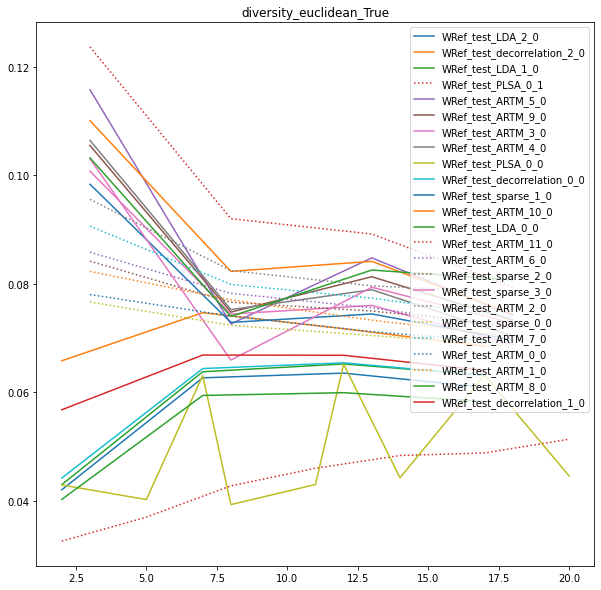

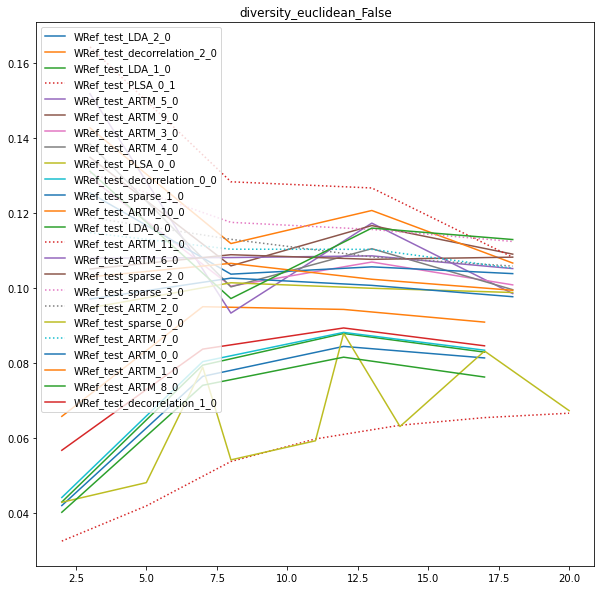

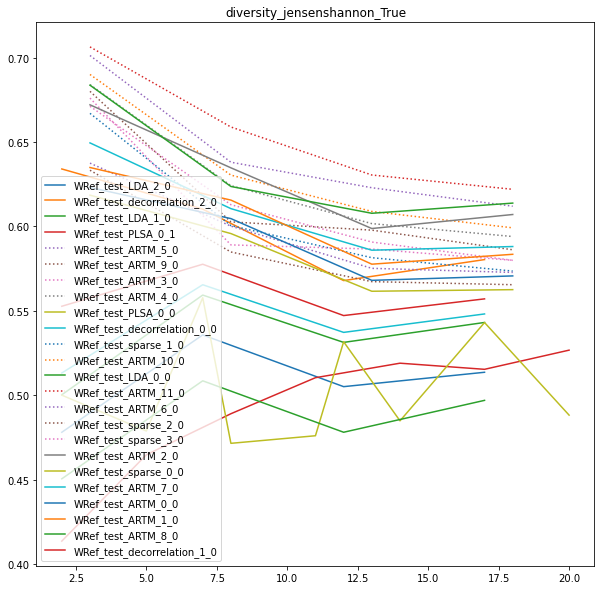

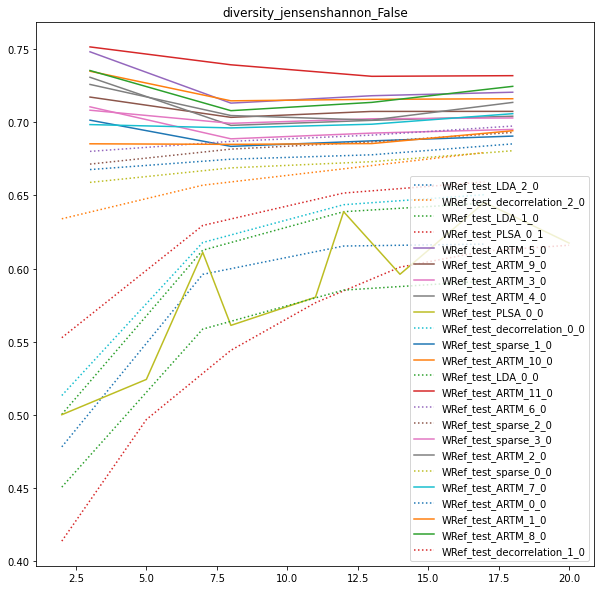

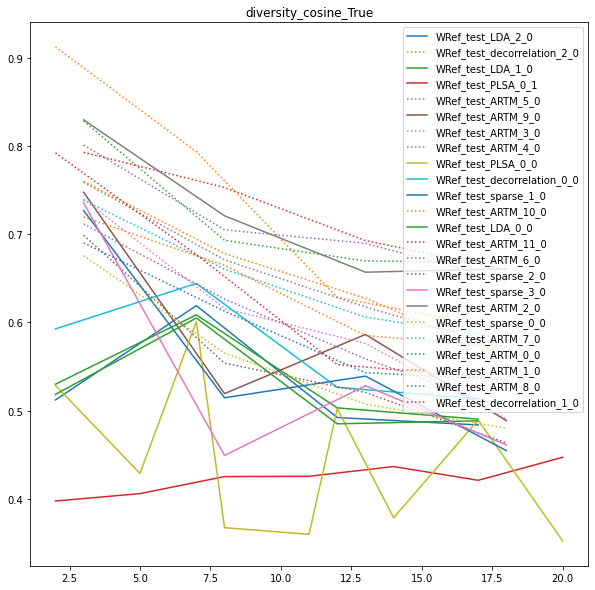

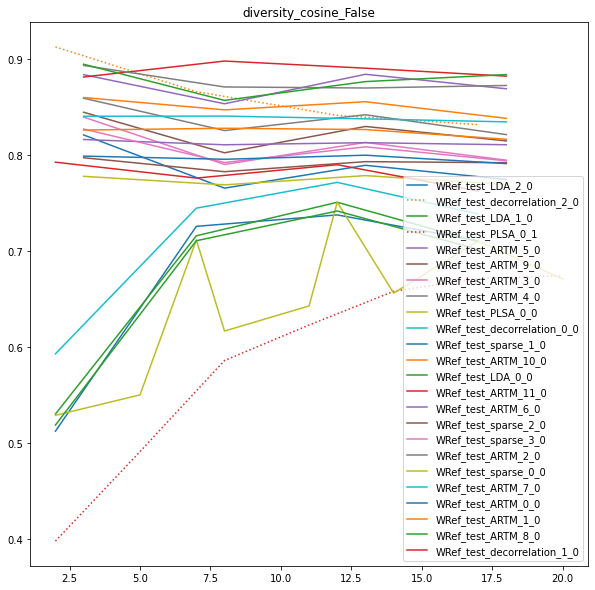

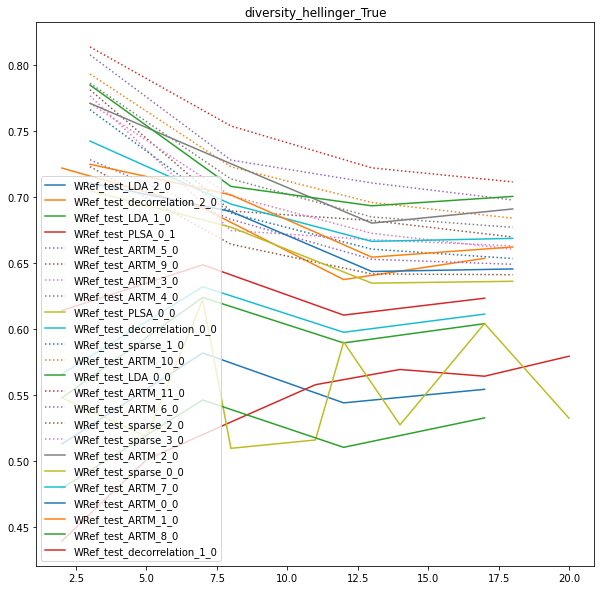

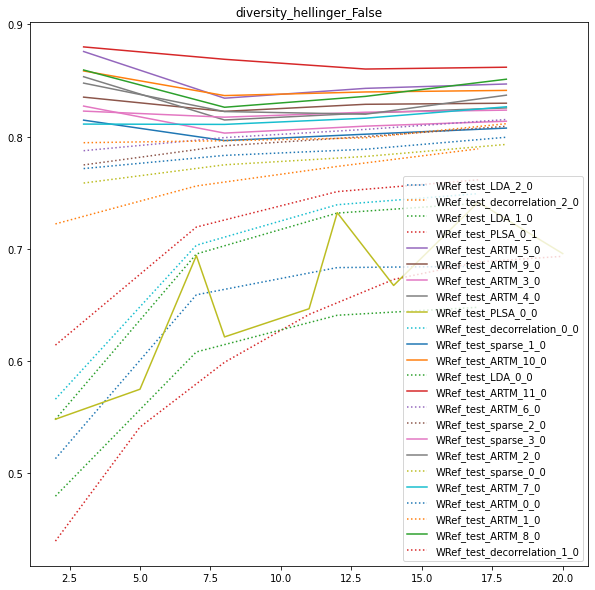

In [22]:
plot_everything_informative(
    EXPERIMENT_DIRECTORY, EXPERIMENT_NAME_TEMPLATE, ["diversity"]
)

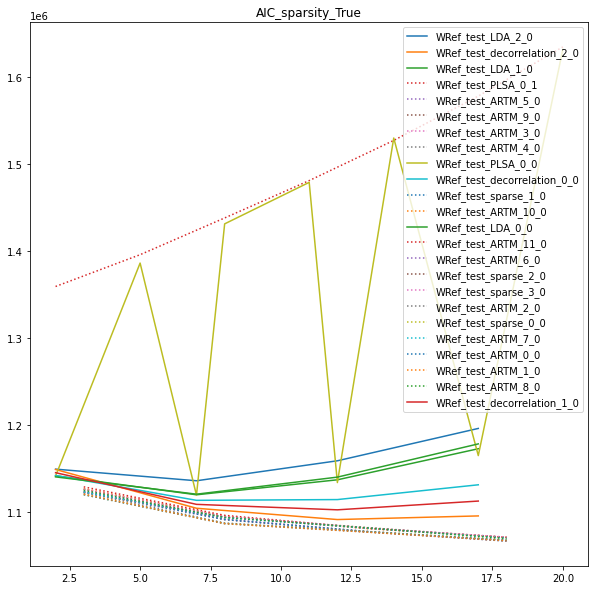

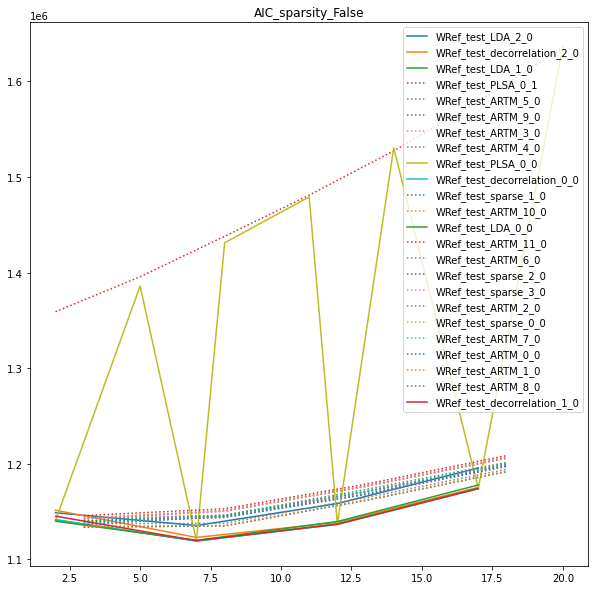

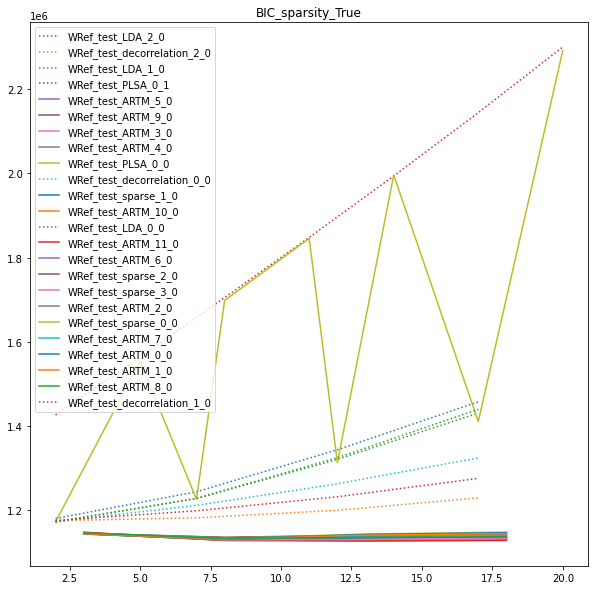

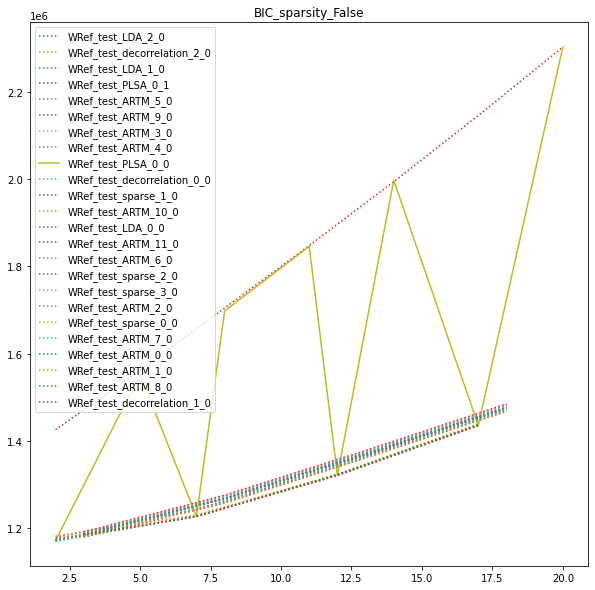

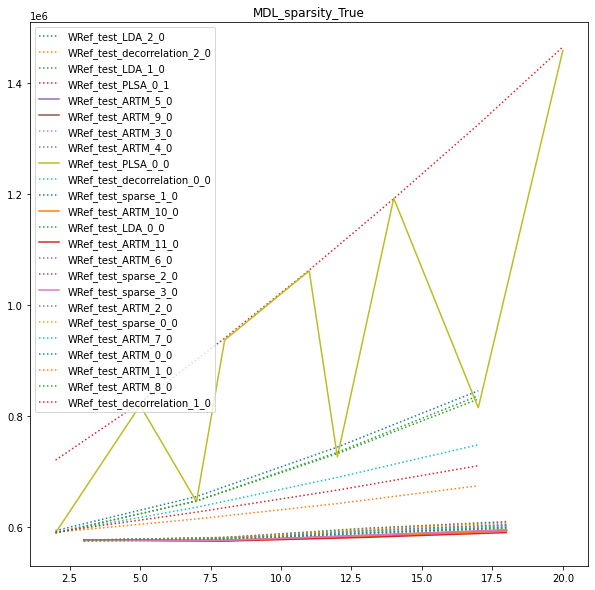

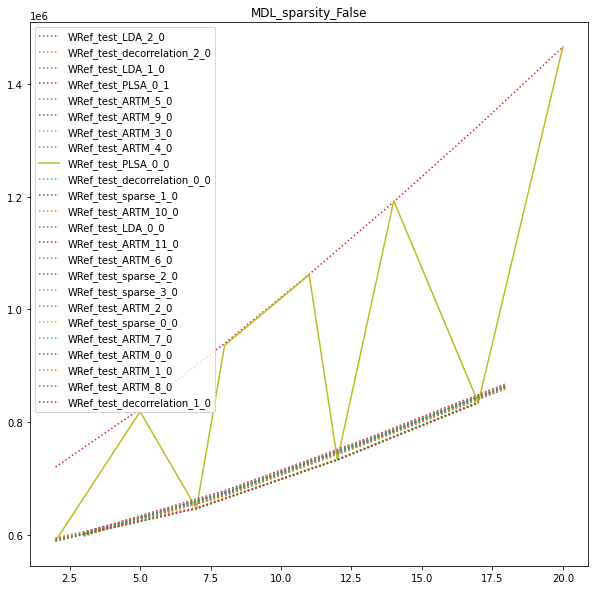

In [23]:
plot_everything_informative(
    EXPERIMENT_DIRECTORY, EXPERIMENT_NAME_TEMPLATE, ["_sparsity"]
)

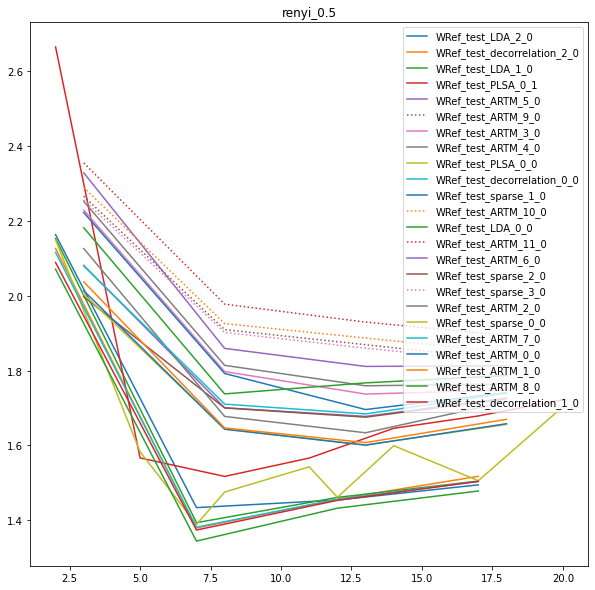

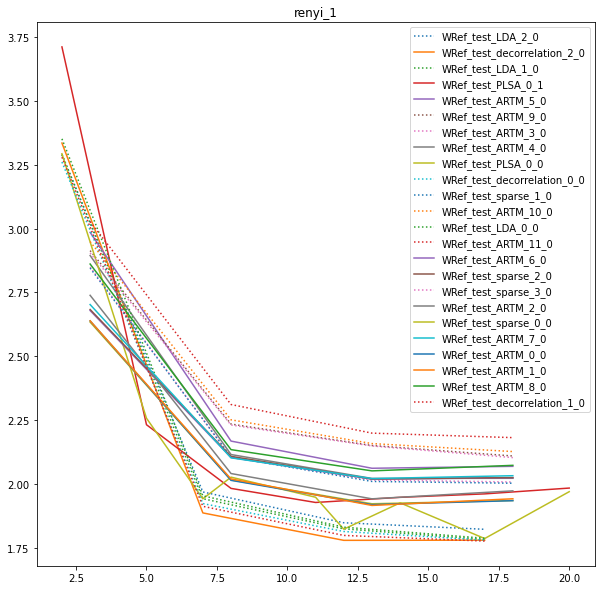

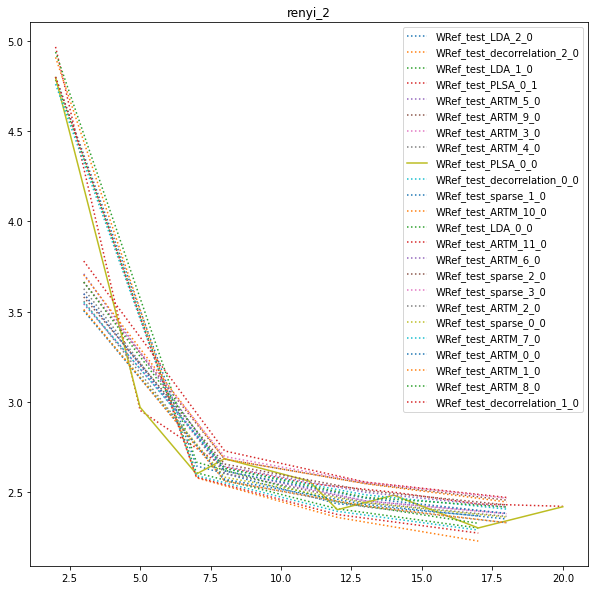

In [24]:
plot_everything_informative(EXPERIMENT_DIRECTORY, EXPERIMENT_NAME_TEMPLATE, ['renyi'])

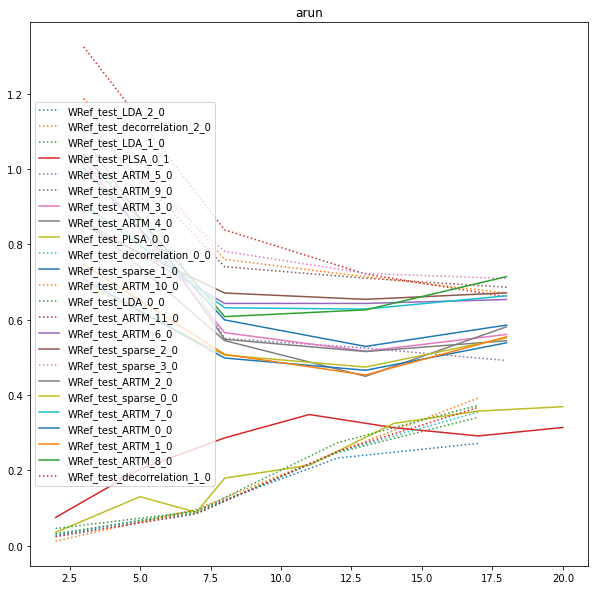

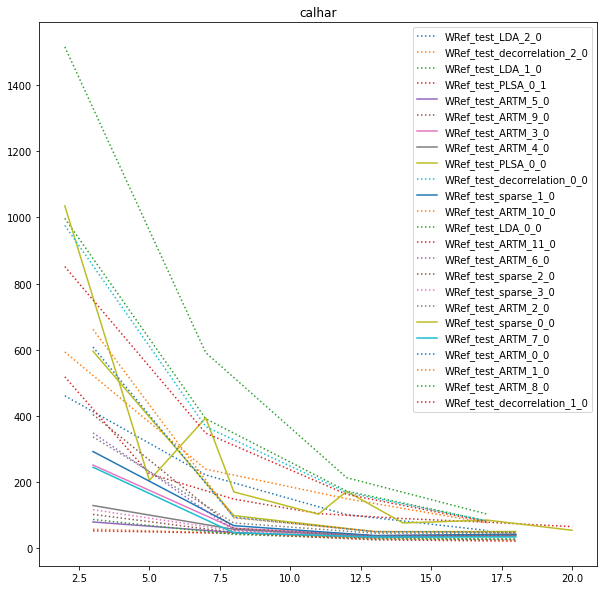

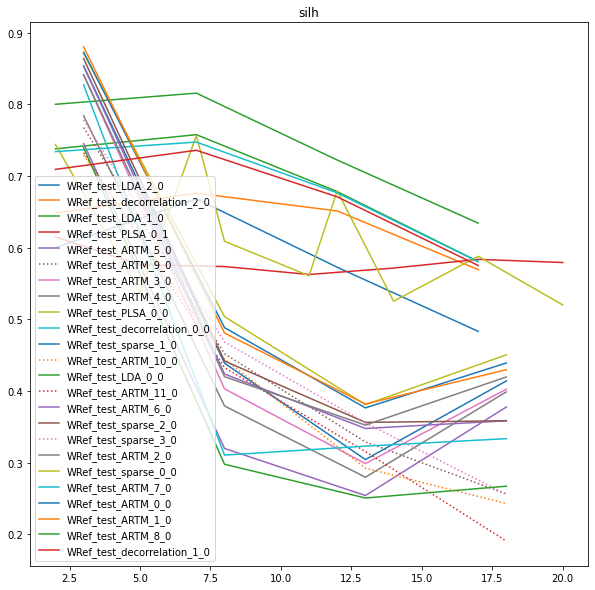

In [25]:
plot_everything_informative(EXPERIMENT_DIRECTORY, EXPERIMENT_NAME_TEMPLATE, ['arun'])
plot_everything_informative(EXPERIMENT_DIRECTORY, EXPERIMENT_NAME_TEMPLATE, ['calhar'])
plot_everything_informative(EXPERIMENT_DIRECTORY, EXPERIMENT_NAME_TEMPLATE, ['silh'])

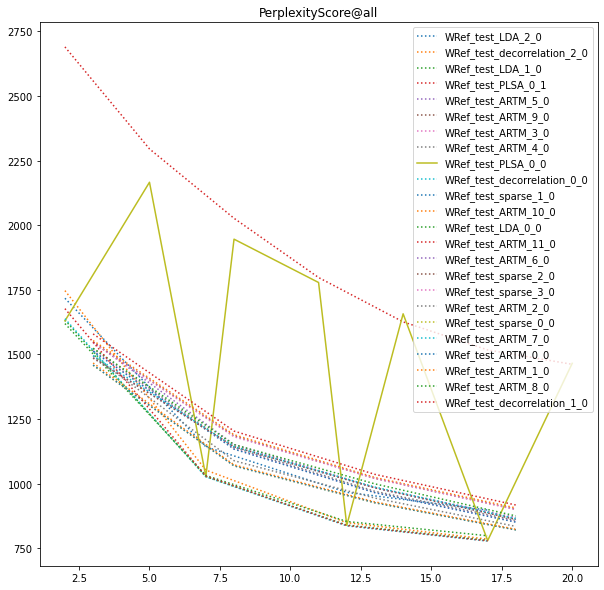

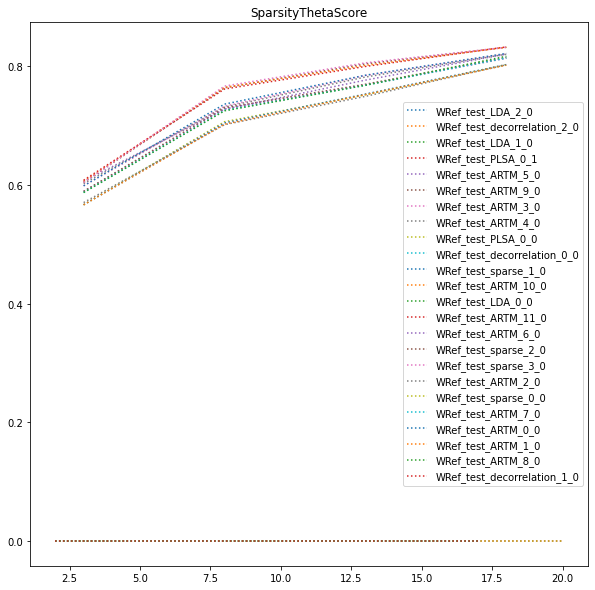

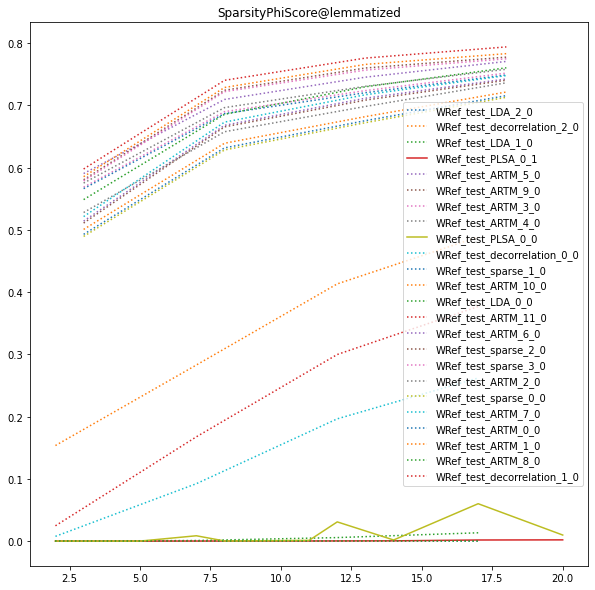

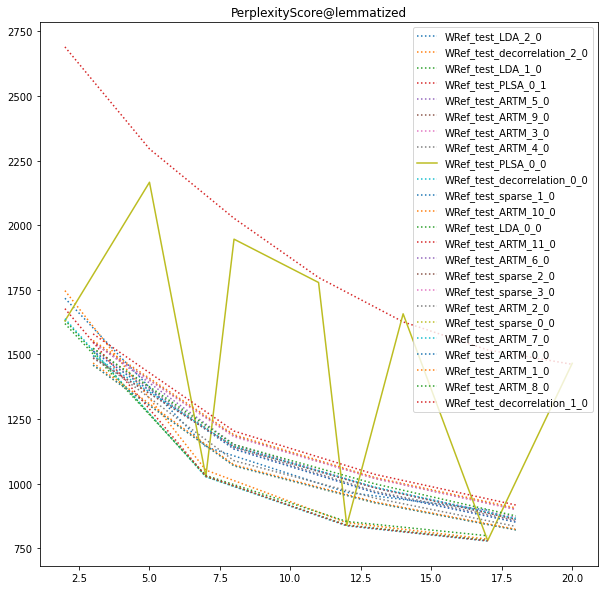

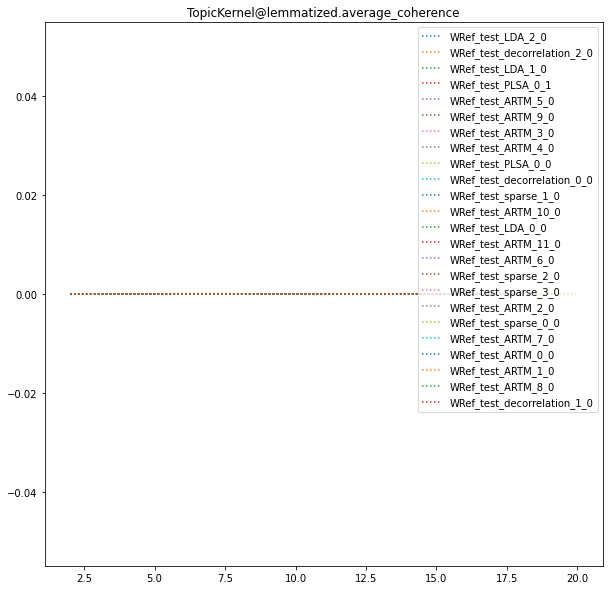

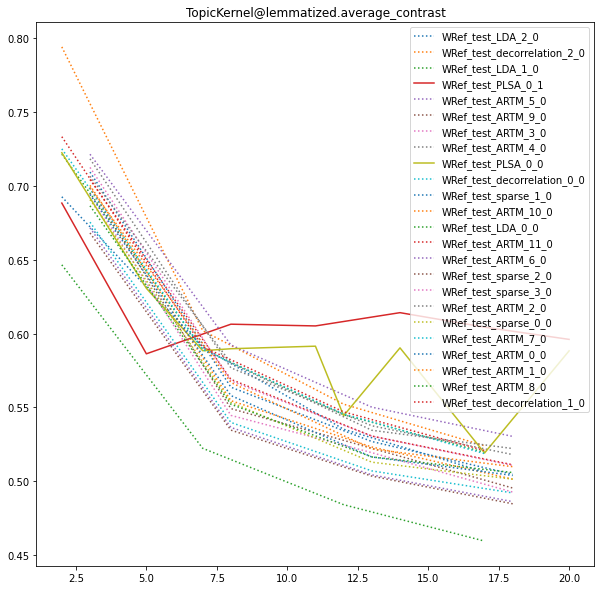

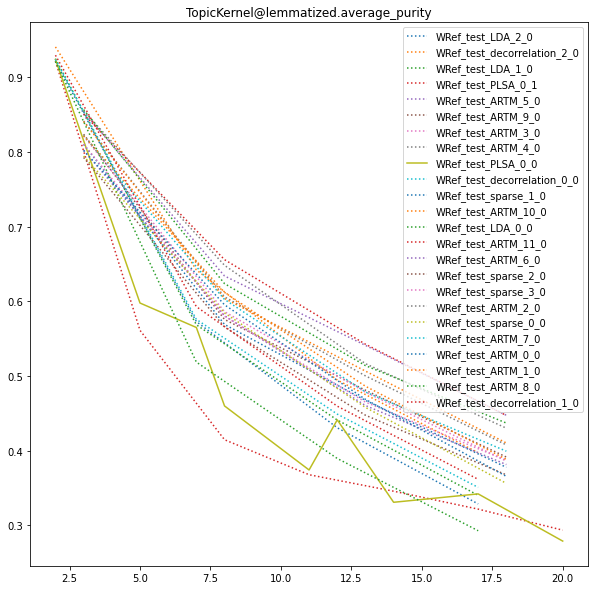

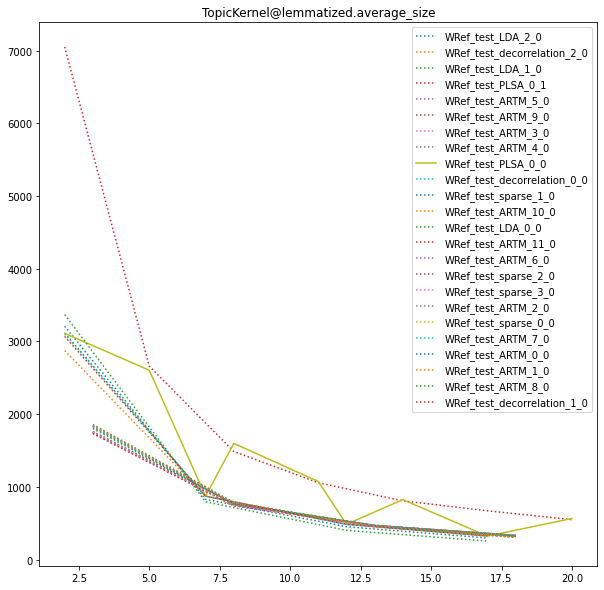

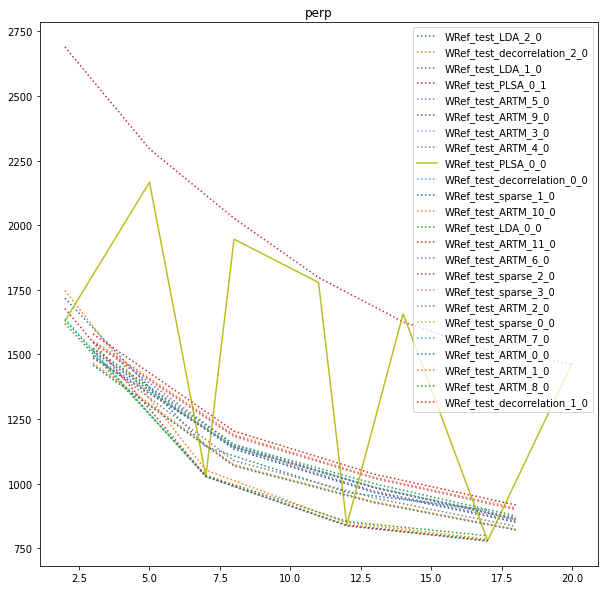

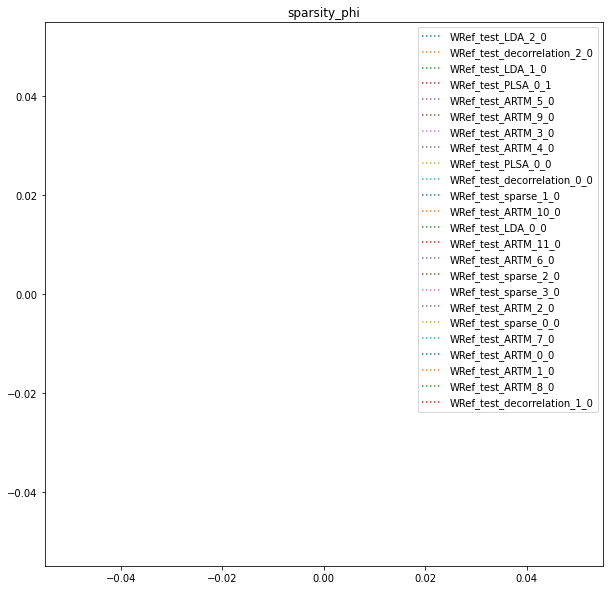

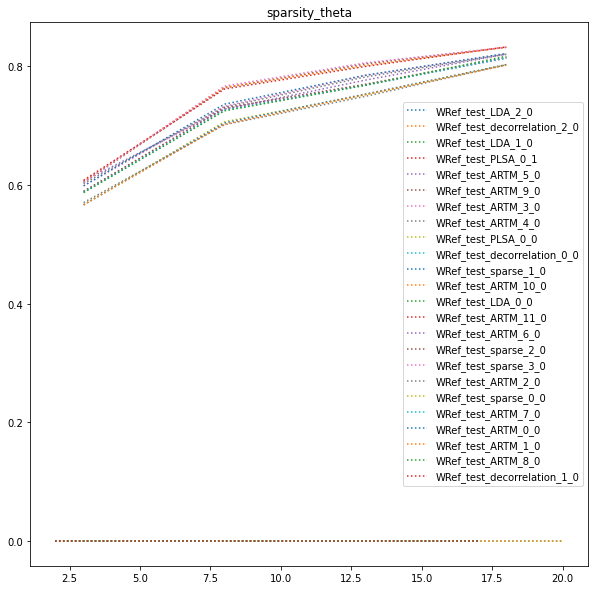

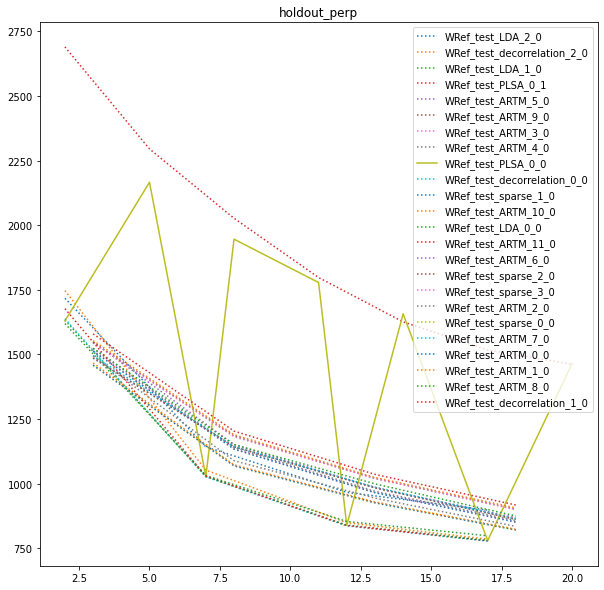

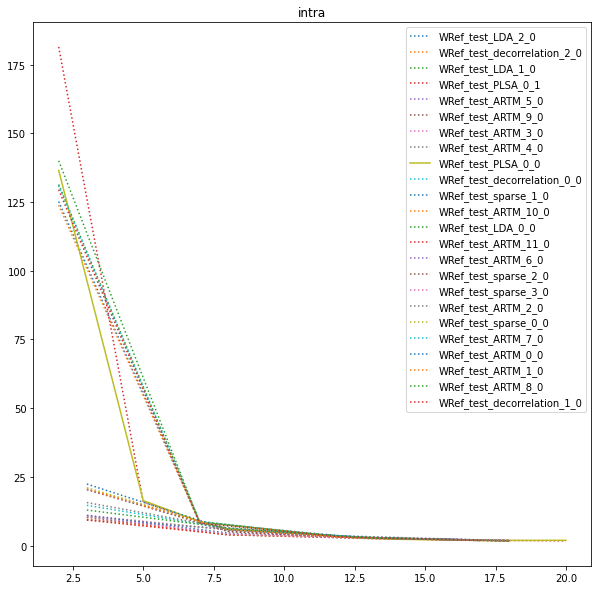

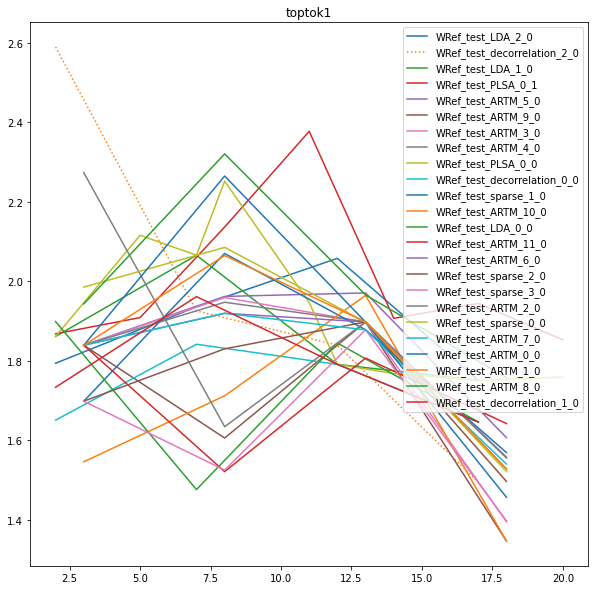

In [26]:
plot_everything_informative(
    EXPERIMENT_DIRECTORY, EXPERIMENT_NAME_TEMPLATE,
    [], 
    ["diversity", "_sparsity", 'renyi', 'arun', 'calhar', 'silh']
)